In [1]:
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Загрузка данных

In [2]:
data = pd.read_csv("Tweets.csv")
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
data.drop(columns=['textID', 'selected_text'], inplace=True)
data = data.dropna(axis=0).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


## Разделение на тренировочную и тестовую выборку

In [4]:
y_factorized, uniques = pd.factorize(data['sentiment'], sort=True)
train_data, test_data = train_test_split(data, stratify=y_factorized, random_state=42)
uniques

Index(['negative', 'neutral', 'positive'], dtype='object')

## EDA
### Посмотрим на распределение классов. Присутствует незначительный дисбаланс

<Axes: >

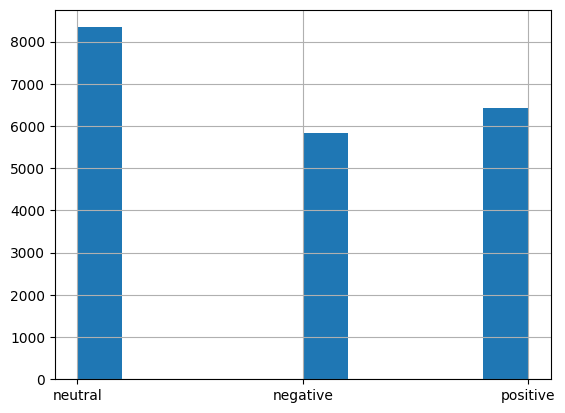

In [5]:
train_data['sentiment'].hist()

### Облако слов

Отобразим распределение самых часто встречающихся слов по классам. Не будем учитывать стоп слова и самые часто встречающиеся слова в датасете (чьё количество превышает 99.5 перцентиль)

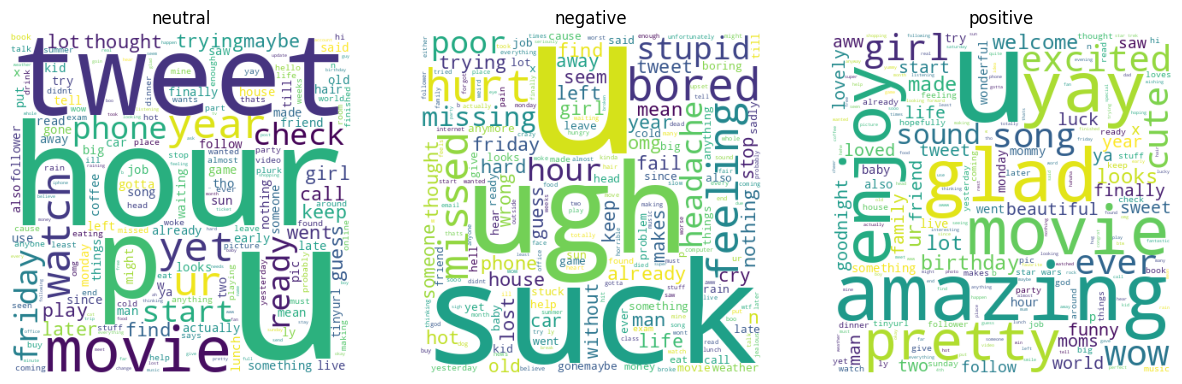

In [6]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

stop_words = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=stop_words)
word_counts = np.asarray(vectorizer.fit_transform(train_data['text']).sum(0)).squeeze()

percentil_99 = np.percentile(word_counts, 99.5)
most_freq_inds = np.nonzero(word_counts > percentil_99)[0]

w2i_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}

for ind in most_freq_inds:
    stop_words.append(w2i_vocab[ind])

stop_words = set(stop_words)
classes = train_data['sentiment'].unique()

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
for i, cls in enumerate(classes):
    cls_data = train_data[train_data['sentiment'] == cls]['text']
    cls_str = ' '.join(cls_data.to_list()).lower()
    cloud = WordCloud(stopwords=stop_words, height=400, background_color='white').generate(cls_str)
    axes[i].imshow(cloud)
    axes[i].set_title(cls)
    axes[i].axis("off")
 
plt.show()

Как можно видеть, распределение самых частых слов отличается в зависимости от класса.

### Распределение по длине

Минимальная длина: 1. Максимальная длина: 106


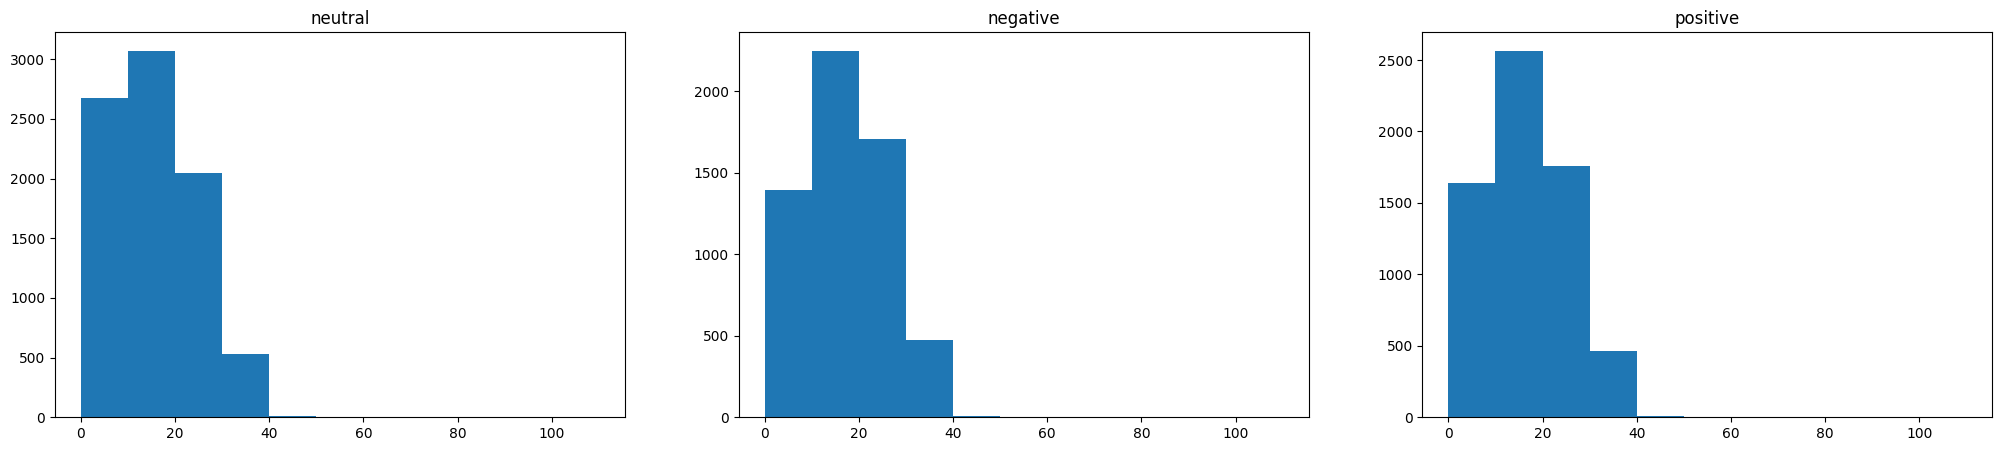

In [7]:
from nltk.tokenize import word_tokenize

text_lens = train_data['text'].apply(word_tokenize).apply(len)

print(f'Минимальная длина: {text_lens.min()}. Максимальная длина: {text_lens.max()}')

fig, axes = plt.subplots(1, 3, figsize=(25, 5))
bins = list(range(0, text_lens.max() + 10, 10))
for i, cls in enumerate(classes):
    cls_lens = text_lens[train_data['sentiment'] == cls]
    axes[i].hist(cls_lens, bins)
    axes[i].set_title(cls)

Распределение по длине почти не отличается между классами. У нейтрального класса больше коротких примеров

##  Подготовка и очистка данных

In [8]:
import re
from nltk.tokenize import word_tokenize
import pymorphy3

def clear_data(df, stopwords):
    morph = pymorphy3.MorphAnalyzer()
    new_df = df.copy()
    new_df['text'] = new_df['text'].apply(lambda text: text.lower())
    new_df['text'] = new_df['text'].apply(lambda text: re.sub('[?!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”)*°(°*``,.]', '', text))
    
    new_df['text'] = new_df['text'].apply(lambda text: word_tokenize(text))
    new_df['text'] = new_df['text'].apply(lambda text: [morph.parse(word)[0].normal_form for word in text if word not in stopwords])
    new_df['text'] = new_df['text'].apply(lambda text: ' '.join(text))
    return new_df

In [9]:
stop_words = stopwords.words('english')
clear_train_data = clear_data(train_data, stop_words)
clear_train_data.head()

,text,sentiment
13544,dm amigui,neutral
2889,got wheres sun =o,neutral
23822,im bored work,negative
22031,cant wait next twitter,positive
22970,tried sleep cant bout call tisha,negative


In [10]:
clear_test_data = clear_data(test_data, stop_words)

## Классические ML алгоритмы
Возьмём 2 классических алгоритма машинного обучения - SVM для задачи классификации, а также RidgeRegression.
В качестве методов векторизации выберем TF-IDF и Word2Vec размерности 300 обученный на Google news

### TF-IDF

In [11]:
def test_model(train_X, train_y, test_X, test_y, model):
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    print(classification_report(test_y, preds, target_names=uniques))

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, f1_score


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,1))
train_X = vectorizer.fit_transform(clear_train_data['text'])
train_y = pd.factorize(clear_train_data['sentiment'], sort=True)[0]

test_X = vectorizer.transform(clear_test_data['text'])
test_y = pd.factorize(clear_test_data['sentiment'], sort=True)[0]

print('SVC model:')
classifier = SVC()
test_model(train_X, train_y, test_X, test_y, classifier)

print('RidgeRegression model:')
classifier = RidgeClassifier()
test_model(train_X, train_y, test_X, test_y, classifier)

SVC model:
              precision    recall  f1-score   support

    negative       0.76      0.56      0.64      1945
     neutral       0.61      0.80      0.69      2779
    positive       0.80      0.67      0.73      2146

    accuracy                           0.69      6870
   macro avg       0.72      0.67      0.69      6870
weighted avg       0.71      0.69      0.69      6870

RidgeRegression model:
              precision    recall  f1-score   support

    negative       0.68      0.61      0.65      1945
     neutral       0.62      0.70      0.66      2779
    positive       0.75      0.69      0.72      2146

    accuracy                           0.67      6870
   macro avg       0.68      0.67      0.68      6870
weighted avg       0.68      0.67      0.67      6870



В обоих моделях наблюдается посредственный результат. Стоит отметить низкий precision у нейтрального класса, что говорит о большом количестве ложно положительных примеров (False Positive). У класса negative присутствует низкое значение Recall (много False Negative), что говорит о его плохой выделяемости на фоне других классов. Положительный класс определяется лучше всего.

## Word2Vec

In [13]:
import gensim
import gensim.downloader
from gensim.models import KeyedVectors
import tqdm


zero_samples = []
def docs_to_vectors(data: pd.DataFrame, vectorizer: KeyedVectors):
    zero_samples_count = 0
    text_data = data['text'].map(word_tokenize)
    all_vector_representation = []
    for document in tqdm.tqdm(text_data):
        doc_words = [word for word in document if word in vectorizer.key_to_index]
        if doc_words:
            vector_representation = sum([np.array(vectorizer[word]) for word in doc_words])
            vector_representation /= np.linalg.norm(vector_representation, ord=2)
        else:
            vector_representation = np.zeros(300,)
            zero_samples_count += 1
            zero_samples.append(document)
            
        all_vector_representation.append(vector_representation)

    all_vector_representation = np.stack(all_vector_representation, axis=0)
    print('Количество примеров, не превращённых в векторы (нулевых векторов):', zero_samples_count)
    return all_vector_representation

In [14]:
vector_type = 'word2vec-google-news-300'
vectors_vocab = gensim.downloader.load(vector_type)

In [15]:
vectorized_data_train = docs_to_vectors(clear_train_data, vectors_vocab)
vectorized_data_test = docs_to_vectors(clear_test_data, vectors_vocab)
print('Примеры посследовательностей, необработанных word2vec:')
print(*zero_samples[:5], sep='\n')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20610/20610 [00:00<00:00, 38593.39it/s]


Количество примеров, не превращённых в векторы (нулевых векторов): 144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6870/6870 [00:00<00:00, 39257.69it/s]

Количество примеров, не превращённых в векторы (нулевых векторов): 52
Примеры посследовательностей, необработанных word2vec:
['yeaaa']
['yess']
['revisingg']
['shoesshoesshoesyayyayyayloliwouldpostatwitpicbutidntknohow']
['guesss']


Как мы можем видеть, не все последовательности Word2Vec способен трансформировать в векторы. Это связано с тем, что он не может распознать некоторые жаргонные слова, не соответствующие привычным формам. Хотя количество полностью пропущенных последовательностей невелико, внутри успешно обработанных последовательностей некоторые слова также могут быть пропущены, что может являться критичным для понимания текстов, особенно, если учесть их небольшую длину.

In [16]:
print('SVC model:')
classifier = SVC()
test_model(vectorized_data_train, train_y, vectorized_data_test, test_y, classifier)

print('RidgeRegression model:')
classifier = RidgeClassifier()
test_model(vectorized_data_train, train_y, vectorized_data_test, test_y, classifier)

SVC model:
              precision    recall  f1-score   support

    negative       0.72      0.65      0.68      1945
     neutral       0.65      0.74      0.69      2779
    positive       0.77      0.70      0.73      2146

    accuracy                           0.70      6870
   macro avg       0.71      0.69      0.70      6870
weighted avg       0.71      0.70      0.70      6870

RidgeRegression model:
              precision    recall  f1-score   support

    negative       0.70      0.64      0.67      1945
     neutral       0.64      0.72      0.68      2779
    positive       0.74      0.68      0.71      2146

    accuracy                           0.69      6870
   macro avg       0.70      0.68      0.69      6870
weighted avg       0.69      0.69      0.69      6870



Как и в случае с TF-IDF, нейтральный класс имеет много False Positive примеров. По сравнению с предыдущим методом векторизации, f1 по разным классам распределён более равномерно.

In [17]:
np.save('w2v_300_train.npy', vectorized_data_train)
np.save('w2v_300_test.npy', vectorized_data_test)

## Нейронные сети
### Попробуем применить 2 архитектуры нейронных сетей, способных работать с последовательностями - сети с одномерными свёртками и LSTM.

In [18]:
import torch
import torch.nn as nn
from torch.optim.adamw import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

torch.manual_seed(42)


class VectorDataset:
    def __init__(self, text_data, y, vectorizer):
        self.text_data = text_data
        self.y = y
        self.vectorizer = vectorizer

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, ind):
        text = self.text_data[ind]
        text = [torch.tensor(self.vectorizer[word]) for word in word_tokenize(text) if word in self.vectorizer.key_to_index]
        if not text:
            return torch.zeros((1, 300)), torch.tensor(self.y[ind])
        return torch.stack(text, axis=0), torch.tensor(self.y[ind])

def data_collator(batch: tuple):
    X = pad_sequence([sample[0] for sample in batch], batch_first=True, padding_side='left')
    y = torch.stack([sample[1] for sample in batch], 0)
    return X, y

def train(model, epochs, optimizer, model_name, train_dataloader, val_dataloader, scheduler=None, device='cuda'):
    loss_fn = nn.CrossEntropyLoss()
    best_f1 = 0
    losses = []
    f1_scores = []
    for epoch in range(epochs):
        avg_loss = 0
        avg_f1 = 0
        model.train()
        for train_iter, (X, y) in tqdm.tqdm(enumerate(train_dataloader), desc='Training'):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            loss.backward()

            optim.step()
            if scheduler is not None:
                scheduler.step()

            optim.zero_grad()

            avg_loss += loss.item()
        model.eval()
        
        all_preds = []
        for val_iter, (X, y) in tqdm.tqdm(enumerate(val_dataloader), desc='Validation'):
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                logits = model(X)
                
            preds = logits.argmax(-1)
            all_preds.append(preds)
            
        all_preds = torch.cat(all_preds)
        f1 = f1_score(test_y, all_preds.cpu().numpy(), average='macro')

        losses.append(avg_loss / (train_iter + 1))
        f1_scores.append(f1)
        print('Epoch:', epoch + 1, 'Loss:', avg_loss / (train_iter + 1), 'F1:', f1)
        if f1 > best_f1:
            best_f1 = f1
            best_preds = all_preds.cpu().numpy()
            torch.save(model, f'{model_name}.pth')

    epochs = list(range(1, epochs + 1))
    fig, axes = plt.subplots(1, 2, figsize=(25, 5))
    
    axes[0].plot(epochs, losses)
    axes[1].plot(epochs, f1_scores)

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Macro F1')

    print(classification_report(test_y, best_preds, target_names=uniques))

In [19]:
train_dataset, val_dataset = VectorDataset(clear_train_data['text'].values, train_y, vectors_vocab), VectorDataset(clear_test_data['text'].values, test_y, vectors_vocab)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=data_collator)

### CNN

In [20]:
class MyCNN(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, num_classes=3):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layer = nn.Sequential(
                nn.Conv1d(input_dim, hidden_size, 3, padding=1),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU()
            )
            layers.append(layer)
            input_dim = hidden_size
        self.layers = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.layers(x.transpose(2, 1))
        x = x.mean(-1) # global avg pool
        x = self.classifier(x)
        return x

Training: 645it [00:06, 97.20it/s] 
Validation: 215it [00:01, 131.42it/s]


Epoch: 1 Loss: 0.7584076538566471 F1: 0.6914737314506275


Training: 645it [00:07, 89.72it/s]
Validation: 215it [00:01, 133.13it/s]


Epoch: 2 Loss: 0.6810503489287325 F1: 0.7166505143792327


Training: 645it [00:07, 89.93it/s]
Validation: 215it [00:01, 132.96it/s]


Epoch: 3 Loss: 0.6253611414007438 F1: 0.7211841098480994


Training: 645it [00:07, 90.03it/s]
Validation: 215it [00:01, 133.21it/s]


Epoch: 4 Loss: 0.5549949693125348 F1: 0.7118706025897188


Training: 645it [00:07, 90.26it/s]
Validation: 215it [00:01, 132.23it/s]


Epoch: 5 Loss: 0.4589606504800708 F1: 0.7082128238106978


Training: 645it [00:07, 89.72it/s]
Validation: 215it [00:01, 132.72it/s]


Epoch: 6 Loss: 0.33987492716820666 F1: 0.7000210434835145


Training: 645it [00:07, 89.70it/s]
Validation: 215it [00:01, 132.55it/s]


Epoch: 7 Loss: 0.22511946352473064 F1: 0.6734647850974086


Training: 645it [00:07, 89.86it/s]
Validation: 215it [00:01, 133.04it/s]


Epoch: 8 Loss: 0.1527259547407775 F1: 0.6793684359667623


Training: 645it [00:07, 90.10it/s]
Validation: 215it [00:01, 132.80it/s]


Epoch: 9 Loss: 0.11002978715727958 F1: 0.6756064854143505


Training: 645it [00:07, 90.32it/s]
Validation: 215it [00:01, 133.04it/s]


Epoch: 10 Loss: 0.09314520161079112 F1: 0.673372132674654
              precision    recall  f1-score   support

    negative       0.67      0.75      0.71      1945
     neutral       0.70      0.68      0.69      2779
    positive       0.80      0.73      0.77      2146

    accuracy                           0.72      6870
   macro avg       0.72      0.72      0.72      6870
weighted avg       0.72      0.72      0.72      6870



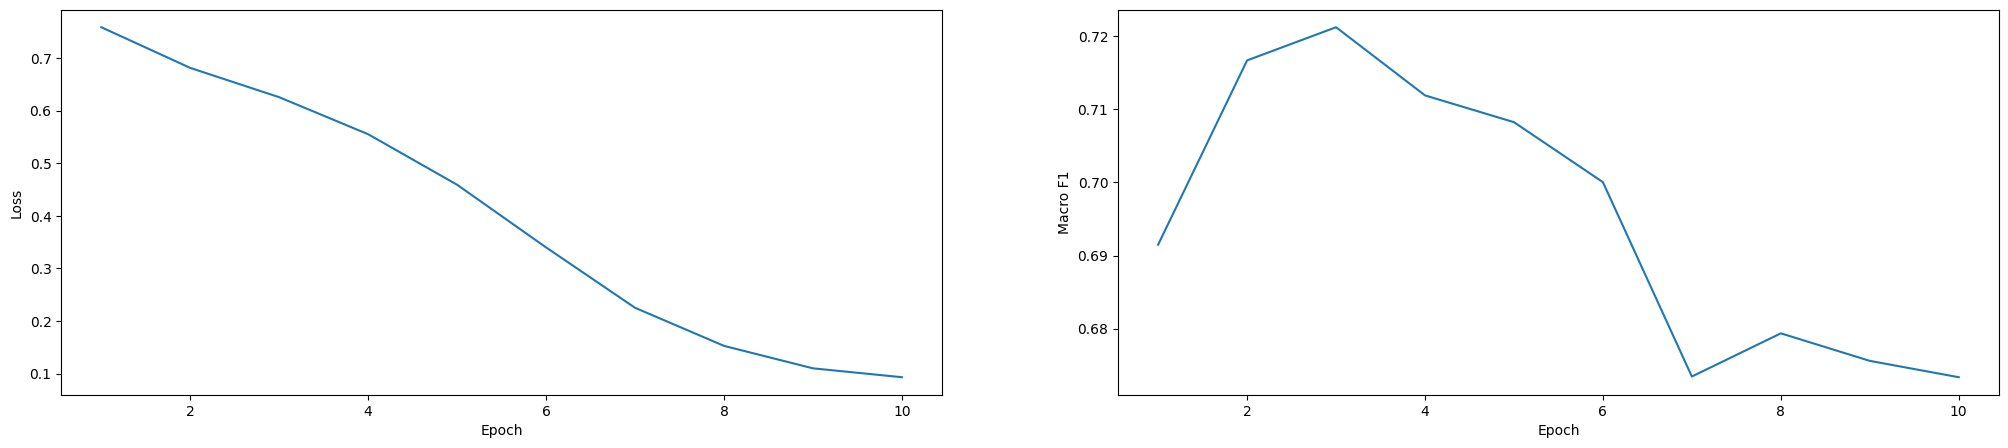

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MyCNN(300, 96, 3).to(device)

epochs = 10
optim = AdamW(model.parameters(), lr=2e-3, weight_decay=0.05)

num_steps = len(train_dataloader) * epochs
scheduler = CosineAnnealingLR(optim, num_steps, 1e-7)

train(model, epochs, optim, 'cnn', train_dataloader, val_dataloader, scheduler, device)

Природа ошибок CNN отличается от предыдущих экспериментов с классическими ML-моделями. Нейтральный класс не имеет сильного проседания по precision, он теперь даже выше, чем recall. Recall других классов также возрос, что говорит о прогрессе в проблеме отделения negative класса от нейтрального.

### LSTM

In [22]:
class MyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size, 
                            num_layers=num_layers, batch_first=True, 
                            dropout=0.05)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.classifier(x[:, -1]) # using last token from sequence
        return x

Training: 645it [00:07, 82.61it/s]
Validation: 215it [00:01, 142.20it/s]


Epoch: 1 Loss: 0.7546983589497648 F1: 0.7375171588540993


Training: 645it [00:07, 89.72it/s]
Validation: 215it [00:01, 141.35it/s]


Epoch: 2 Loss: 0.6525559789450593 F1: 0.739891530539436


Training: 645it [00:07, 89.21it/s]
Validation: 215it [00:01, 144.49it/s]


Epoch: 3 Loss: 0.6215298707171004 F1: 0.7362433403250357


Training: 645it [00:07, 89.06it/s]
Validation: 215it [00:01, 142.29it/s]


Epoch: 4 Loss: 0.5912003450615462 F1: 0.7388625016566914


Training: 645it [00:07, 89.10it/s]
Validation: 215it [00:01, 143.43it/s]


Epoch: 5 Loss: 0.5527225271213886 F1: 0.7298475722747652


Training: 645it [00:07, 89.47it/s]
Validation: 215it [00:01, 142.86it/s]


Epoch: 6 Loss: 0.5049228960229445 F1: 0.716255165363403


Training: 645it [00:07, 89.90it/s]
Validation: 215it [00:01, 142.48it/s]


Epoch: 7 Loss: 0.45337482168115384 F1: 0.7287657853132563


Training: 645it [00:07, 88.95it/s]
Validation: 215it [00:01, 141.73it/s]


Epoch: 8 Loss: 0.40546187743429063 F1: 0.7246798946703227


Training: 645it [00:07, 90.70it/s] 
Validation: 215it [00:01, 140.34it/s]


Epoch: 9 Loss: 0.36772059316551964 F1: 0.7248076075325


Training: 645it [00:06, 92.14it/s] 
Validation: 215it [00:01, 141.26it/s]


Epoch: 10 Loss: 0.3510479996024176 F1: 0.7238903853303515
              precision    recall  f1-score   support

    negative       0.76      0.69      0.72      1945
     neutral       0.70      0.73      0.71      2779
    positive       0.78      0.79      0.78      2146

    accuracy                           0.74      6870
   macro avg       0.74      0.74      0.74      6870
weighted avg       0.74      0.74      0.74      6870



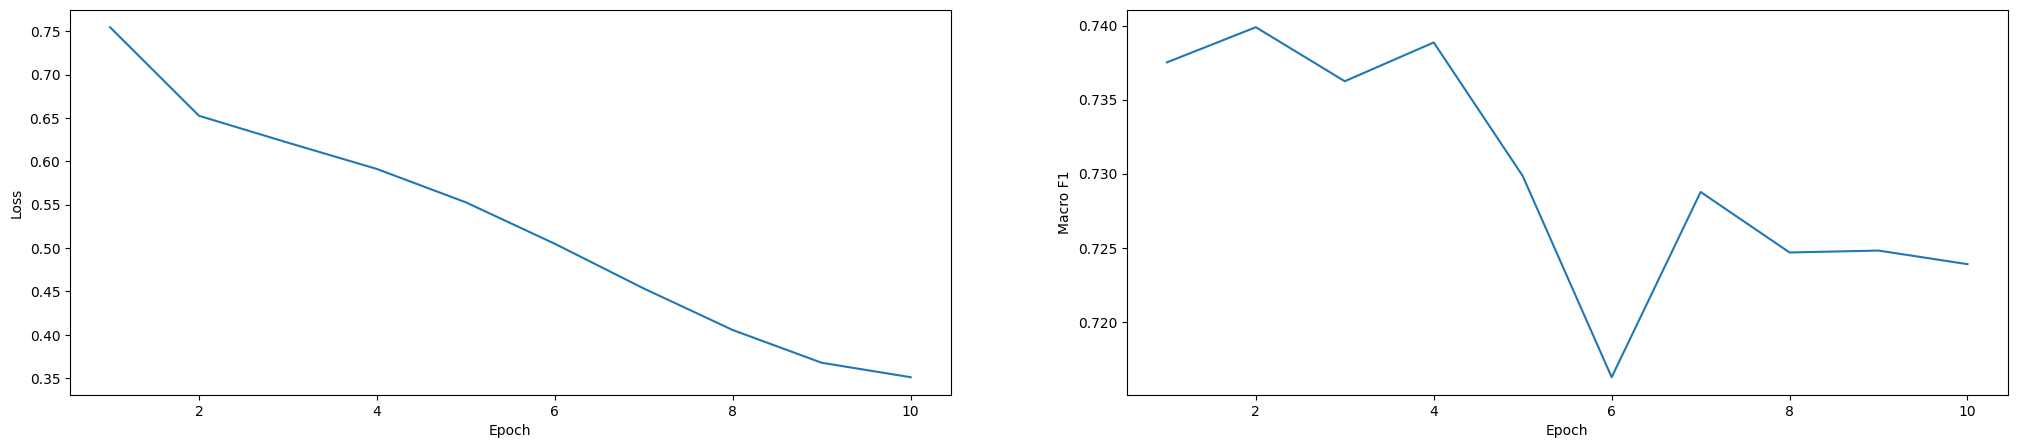

In [23]:
model = MyLSTM(300, 96, 3).to(device)

epochs = 10
optim = AdamW(model.parameters(), lr=2e-3, weight_decay=0.05)

num_steps = len(train_dataloader) * epochs
scheduler = CosineAnnealingLR(optim, num_steps, 1e-7)

train(model, epochs, optim, 'lstm', train_dataloader, val_dataloader, scheduler, device)

Позитивный класс определяется лучше всего. В отличии от CNN, негативный класс снова чаще определяется как какой-то другой.

### Попробуем тренировать нейронные сети без удаления стоп-слов и чистки от мусора, как это делается для современных больших языковых моделей.

In [28]:
def tokenize_data(df):
    morph = pymorphy3.MorphAnalyzer()
    new_df = df.copy()
    new_df['text'] = new_df['text'].apply(lambda text: word_tokenize(text.lower()))
    new_df['text'] = new_df['text'].apply(lambda text: [morph.parse(word)[0].normal_form for word in text])
    new_df['text'] = new_df['text'].apply(lambda text: ' '.join(text))
    return df

In [29]:
train_dataset, val_dataset = VectorDataset(tokenize_data(train_data)['text'].values, train_y, vectors_vocab), VectorDataset(tokenize_data(test_data)['text'].values, test_y, vectors_vocab)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=data_collator)

### CNN

Training: 645it [00:10, 63.18it/s]
Validation: 215it [00:02, 82.09it/s]


Epoch: 1 Loss: 0.7646810587524444 F1: 0.7069130754862082


Training: 645it [00:10, 59.21it/s]
Validation: 215it [00:02, 82.38it/s]


Epoch: 2 Loss: 0.6807170493196147 F1: 0.7266286057294945


Training: 645it [00:10, 59.25it/s]
Validation: 215it [00:02, 80.83it/s]


Epoch: 3 Loss: 0.6274907305259113 F1: 0.737740057880202


Training: 645it [00:10, 59.33it/s]
Validation: 215it [00:02, 82.38it/s]


Epoch: 4 Loss: 0.5588492622671202 F1: 0.7328247180025959


Training: 645it [00:10, 59.19it/s]
Validation: 215it [00:02, 82.25it/s]


Epoch: 5 Loss: 0.4603786673194678 F1: 0.7103946443425624


Training: 645it [00:10, 59.79it/s]
Validation: 215it [00:02, 82.57it/s]


Epoch: 6 Loss: 0.3605349110887032 F1: 0.7123656765860774


Training: 645it [00:10, 59.76it/s]
Validation: 215it [00:02, 82.63it/s]


Epoch: 7 Loss: 0.25098637417536374 F1: 0.7132663729500885


Training: 645it [00:10, 59.20it/s]
Validation: 215it [00:02, 80.77it/s]


Epoch: 8 Loss: 0.17297744147421779 F1: 0.7182261197082708


Training: 645it [00:10, 59.76it/s]
Validation: 215it [00:02, 82.50it/s]


Epoch: 9 Loss: 0.13337650793756164 F1: 0.711134720933079


Training: 645it [00:10, 59.58it/s]
Validation: 215it [00:02, 80.58it/s]


Epoch: 10 Loss: 0.11556729436671549 F1: 0.7106955512813253
              precision    recall  f1-score   support

    negative       0.73      0.76      0.74      1945
     neutral       0.68      0.72      0.70      2779
    positive       0.82      0.73      0.77      2146

    accuracy                           0.73      6870
   macro avg       0.74      0.74      0.74      6870
weighted avg       0.74      0.73      0.73      6870



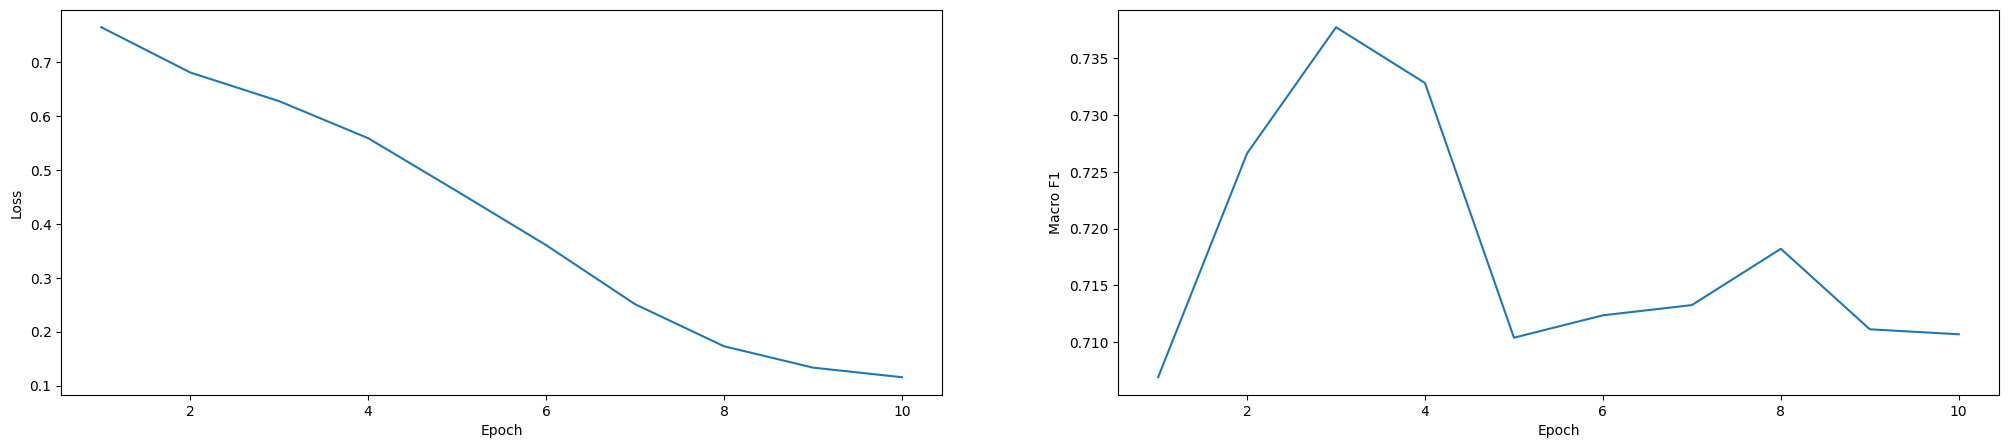

In [30]:
model = MyCNN(300, 96, 3).to(device)

epochs = 10
optim = AdamW(model.parameters(), lr=2e-3, weight_decay=0.05)

num_steps = len(train_dataloader) * epochs
scheduler = CosineAnnealingLR(optim, num_steps, 1e-7)

train(model, epochs, optim, 'cnn', train_dataloader, val_dataloader, scheduler, device)

### LSTM

Training: 645it [00:10, 58.75it/s]
Validation: 215it [00:02, 85.79it/s]


Epoch: 1 Loss: 0.7912813254105028 F1: 0.728999132549212


Training: 645it [00:10, 60.01it/s]
Validation: 215it [00:02, 86.38it/s]


Epoch: 2 Loss: 0.6431729072748229 F1: 0.7442350380744404


Training: 645it [00:10, 60.79it/s]
Validation: 215it [00:02, 85.79it/s]


Epoch: 3 Loss: 0.5984835020677988 F1: 0.7487162604613888


Training: 645it [00:10, 58.72it/s]
Validation: 215it [00:02, 87.90it/s]


Epoch: 4 Loss: 0.561039707318757 F1: 0.760268719529554


Training: 645it [00:10, 60.48it/s]
Validation: 215it [00:02, 87.01it/s]


Epoch: 5 Loss: 0.523346166532169 F1: 0.7653120204587651


Training: 645it [00:10, 59.73it/s]
Validation: 215it [00:02, 86.66it/s]


Epoch: 6 Loss: 0.47924665621546814 F1: 0.757675807158596


Training: 645it [00:10, 59.21it/s]
Validation: 215it [00:02, 87.47it/s]


Epoch: 7 Loss: 0.4317779183156731 F1: 0.7528783463809252


Training: 645it [00:10, 59.08it/s]
Validation: 215it [00:02, 86.41it/s]


Epoch: 8 Loss: 0.3891774493363477 F1: 0.7495345098200034


Training: 645it [00:10, 59.04it/s]
Validation: 215it [00:02, 85.86it/s]


Epoch: 9 Loss: 0.3574090434714805 F1: 0.7501784393699791


Training: 645it [00:10, 58.91it/s]
Validation: 215it [00:02, 85.76it/s]


Epoch: 10 Loss: 0.3442350233363551 F1: 0.7477737026406084
              precision    recall  f1-score   support

    negative       0.75      0.78      0.76      1945
     neutral       0.73      0.73      0.73      2779
    positive       0.82      0.79      0.80      2146

    accuracy                           0.76      6870
   macro avg       0.77      0.77      0.77      6870
weighted avg       0.76      0.76      0.76      6870



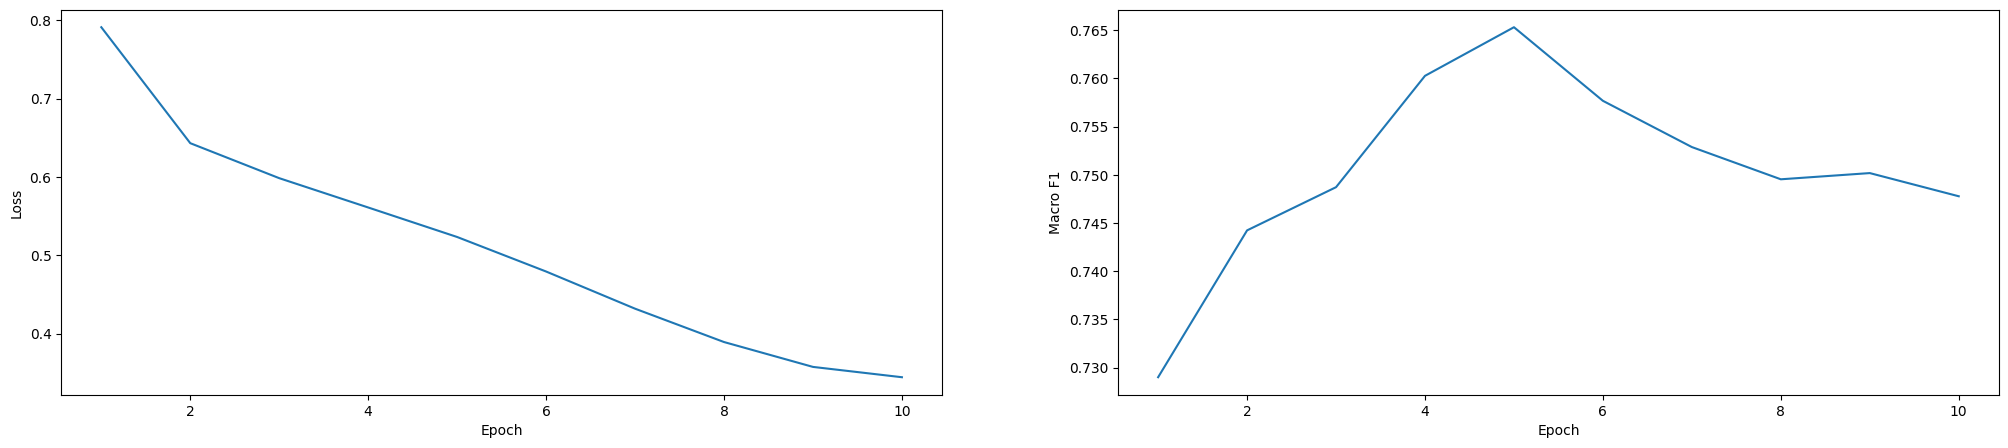

In [31]:
model = MyLSTM(300, 96, 3).to(device)

epochs = 10
optim = AdamW(model.parameters(), lr=2e-3, weight_decay=0.05)

num_steps = len(train_dataloader) * epochs
scheduler = CosineAnnealingLR(optim, num_steps, 1e-7)

train(model, epochs, optim, 'lstm', train_dataloader, val_dataloader, scheduler, device)

Без удаления стоп-слов и прочей очистки данных, результаты существенно улучшились. Так как задача состоит в предсказании настроения, стоп-слова, их количество, всякого рода отрицания могут многое сказать о тональности текста.

### Вывод по нейронным сетям
Поскольку для обоих моделей при уменьшении тренировочного лосса уменьшается также и валидационная метрика, можно с уверенностью сказать о таком явлении как переобучение. Возможно, дело в слишком большом количестве обучаемых параметров сетей. Или же, использование в качестве входных ембеддингов векторов из Word2Vec является не лучшим способом представления данных из-за пропуска некоторых слов. Результаты без жесткой обработки текста сильно лучше, чем результаты с обработкой, что по нашему мнению обусловлено спецификой задачи.